In [1]:
import torch
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn

[*********************100%%**********************]  1 of 1 completed


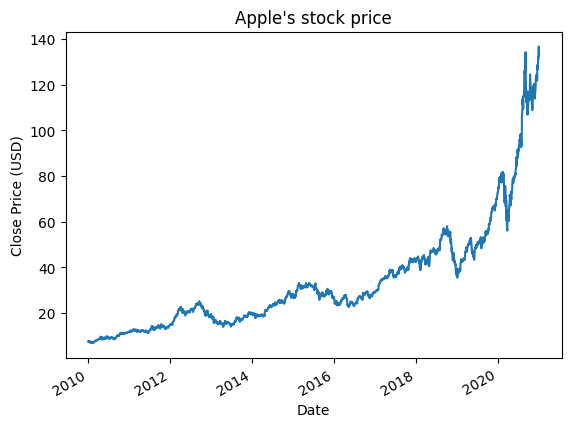

In [2]:
data = yf.download('AAPL', start='2010-01-01', end='2021-01-01')
data['Close'].plot(title="Apple's stock price")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.show()

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
close_price = data['Close'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(close_price)

In [4]:
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [5]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [7]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [9]:
epochs = 150
for epoch in range(epochs):
    for seq, labels in zip(trainX_tensor, trainY_tensor):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'epoch: {epoch:3} loss: {single_loss.item():10.10f}')

/Users/pingw220/Coding/ML/Stock Price Prediction/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.0004225002
epoch:  25 loss: 0.0000243039
epoch:  50 loss: 0.0000015881
epoch:  75 loss: 0.0000006669
epoch: 100 loss: 0.0000502872
epoch: 125 loss: 0.0000298718


In [10]:
model.eval()
test_predictions = []
with torch.no_grad():
    for seq in testX_tensor:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        test_predictions.append(model(seq).item())

test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))

In [11]:
test_mse = mean_squared_error(testY_actual, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(testY_actual, test_predictions)

print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

Test MSE: 1182.546479458564
Test RMSE: 34.38817354060206
Test MAE: 20.47890188599732


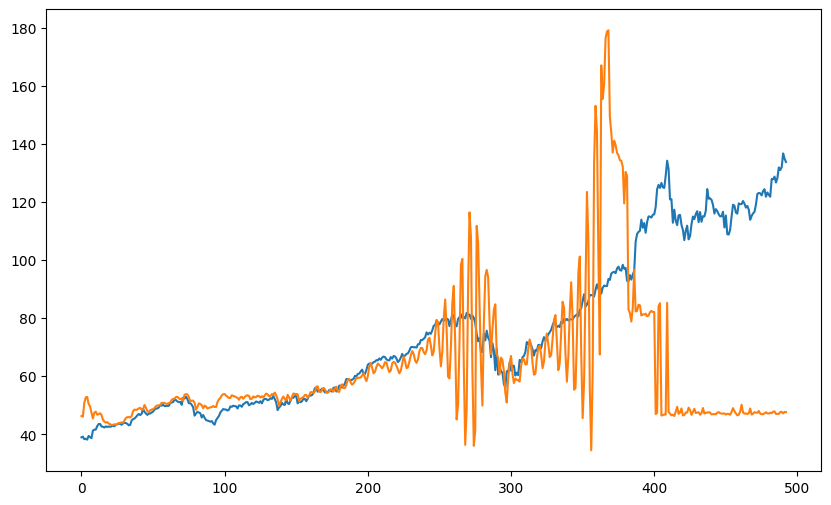

In [12]:
plt.figure(figsize=(10,6))
plt.plot(testY_actual, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')